# Welcome back to Week 4

This week we will look into the analysis of variance (ANOVA) and how we can implement both one-way and two-way ANOVA models.

## Demo 1: F-distribution

The first thing we have to understand before we can implement ANOVA is the F-distribution. You will remember from the lecture that the F-distribution is roughly equal to the t-distribution squared.

If you want to visualise this, you can have a look at the following demo. We will  visualise

- F-distribution with 1 and 19 degrees of freedom
- t-distribution with 19 degrees of freedom
- t-distribution with 19 degrees of freedom but SQUARED

array([3.08897318, 2.66711039, 3.5681412 , ..., 0.2010744 , 1.93470659,
       3.66122222])
array([1.91986621e-01, 6.40541440e+00, 6.91834178e-04, ...,
       2.66698393e+00, 1.88805157e+00, 1.02490494e+00])


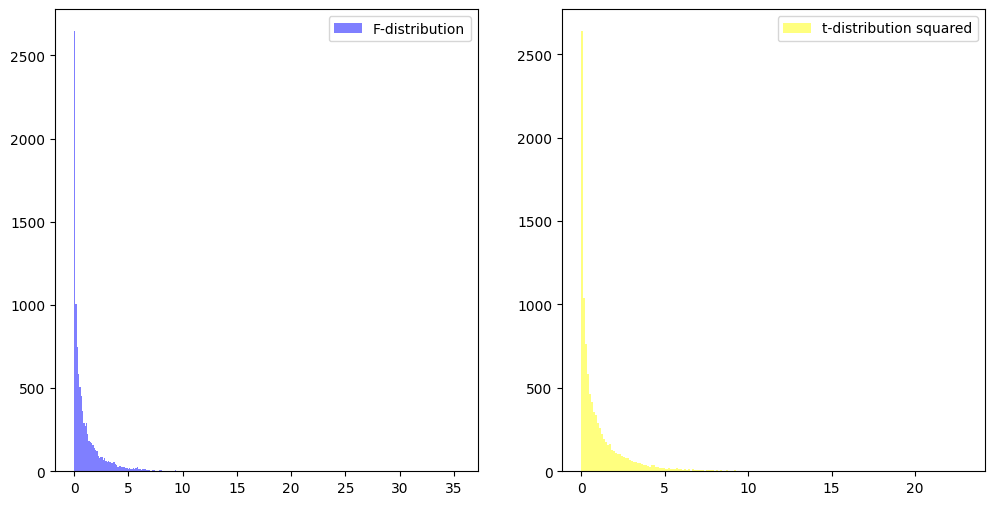

In [1]:
import pprint as pp
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np

# generate 1000 realisations of the three chosen distributions
F_Ran = sts.f.rvs(1, 19, size=10000)
t_Ran = sts.t.rvs(19, loc=0, scale=1, size=10000)
t_Ran_2 = t_Ran**2

pp.pprint(F_Ran)
pp.pprint(t_Ran_2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# plot the results; choose different colours and levels of transparency (3rd and 4th parameter) to plot them together in one
# plt.hist(t_Ran, bins="auto", alpha=0.5, color="green", label="t-distribution")
ax[0].hist(F_Ran, bins="auto", alpha=0.5, color="blue", label="F-distribution")
ax[0].legend()
ax[1].hist(
    t_Ran_2, bins="auto", alpha=0.5, color="yellow", label="t-distribution squared"
)
ax[1].legend()

## Part 2: One-way ANOVA

You are given the following exam scores for different course delivery formats.

| Index | Online | Hybrid | Face-to-Face |
| --- | --- | --- | --- |
| 1 | 72 | 83 | 80 |
| 2 | 84 | 73 | 78 |
| 3 | 77 | 84 | 84 |
| 4 | 80 | 81 | 81 | 
| 5 | 81 |    | 86 | 
| 6 |    |    | 79 | 
| 7 |    |    | 82 | 

We want to conduct a one-way ANOVA, where exam score is our measurement and our three groups are the course delivery formats.

First step is therefore to:
- Formulate a omnibus null hypothesis for one-way ANOVA.

$H_0: \mu_{online} = \mu_{hybrid} = \mu_{f2f}$

For this analysis we then have to follow the following steps:

**1. Check Assumptions**
- Perform the Chi-squared goodness of fit test to check the normality assumption under type I error 5%.
- Perform the Levene's test (scipy.stats.levene) to check if all groups have equal variances under type I error 5%, please refer to [documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html).

**2. Calculate the degrees of freedom and variations for our test statistic calculations later**
- Compute degrees of freedom for among and within -group variations.
- Calculate among-group and within-group variations.

**3. Follow the critical region approach to check the null hypothesis**
- Fix the type I error at 5% and visualise the critial region.
- Compute the test statistic and make the decision by using critical region approach.

### 2.1 Checking assumptions

**DEMO** I will first demonstrate how to check the assumptions for the "online" data. 

In [2]:
import scipy.stats as sts
import numpy as np

# Objective: Perform the Chi-squared goodness of fit test to check the normality assumption under type I error 5%

# We know that a random variable that follows normal distribution is continuous.
# For Chi-squared goodness of fit test, the test statistic is summing the squared difference between the observed frequency and the expected frequency of an outcome.
# Continuous normal distribution means a infinite number of outcomes.
# Hence, we should discretise the continuous normal distribution by using bins/sub-regions.
Group1 = np.array([72, 84, 77, 80, 81])
Group2 = np.array([83, 73, 84, 81])
Group3 = np.array([80, 78, 84, 86, 81, 79, 82])

# Chi-squared goodness of fit test is a one-sample test, meaning that compare population parameters with fixed values
# the fixed values are the population parameters of the normal distribution. Each group follow a normal distribution
# Use sample mean and variance as unbiased estimators of popluation mean and variance.
mean_G = np.zeros((3, 1))
var_G = np.zeros((3, 1))

# ddof is delta degree of freedom, ddof=1: using sample mean formula
mean_G[0, 0] = np.mean(Group1)
var_G[0, 0] = np.var(Group1, ddof=1)

# Let the number of bins be 6, so we devide the PDF of N~(mean_G1/2/3,var_G1/2/3) into 6 regions of equal probability.
# large number of bins, better approximation of normal distribution
# 6 here is because our sample data is a relatively small.
# Cutoffs for those bins can be found via the inverse function of CDF
# 6 bins require 5 cutoffs.
Bin_Cutoff = np.zeros((5, 3))
for i in range(5):
    for j in range(3):
        Bin_Cutoff[i, j] = sts.norm.ppf(
            (i + 1) / 6, loc=mean_G[j, 0], scale=np.sqrt(var_G[j, 0])
        )

# all bins have equal probabilities, the sum is 1.
Expected_Relative_Freq = np.ones((6, 3)) * 1 / 6

# Compute the observed absolute frequency for each bin by counting the number of sample points in each bin
Observed_Absolute_Freq = np.zeros((6, 3))
Observed_Absolute_Freq[0, 0] = len(np.where(Group1 <= Bin_Cutoff[0, 0])[0])


for i in range(1, 5):
    Observed_Absolute_Freq[i, 0] = len(
        np.where(Group1 <= Bin_Cutoff[i, 0])[0]
    ) - np.sum(Observed_Absolute_Freq[0:i, 0])
    Observed_Absolute_Freq[5, 0] = len(Group1) - np.sum(Observed_Absolute_Freq[0:5, 0])


# Compute the expected absolute frequency for each bin: bin probability x sample size of each group
Expected_Absolute_Freq = np.zeros((6, 3))
Expected_Absolute_Freq[:, 0] = Expected_Relative_Freq[:, 0] * len(Group1)


# compute p value for each group by using chi square goodness of fit test;ddof=2: we lost 2 degrees of freedom when estimating population mean and varaince
print(
    "p-value is",
    sts.chisquare(Observed_Absolute_Freq[:, 0], Expected_Absolute_Freq[:, 0], ddof=2)[
        1
    ],
)
print("null hypothesis for group online should be retained, as p-value> 5% ")

p-value is 0.8012519569012009
null hypothesis for group online should be retained, as p-value> 5% 


c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


**TASK**: Replicate the above for the groups "hybrid" and "face to face".

You can add lines of code to the above if you like, as it is already designed to loop over more than one group.

In [13]:
import scipy.stats as sts
import numpy as np

# Objective: Perform the Chi-squared goodness of fit test to check the normality assumption under type I error 5%

# We know that a random variable that follows normal distribution is continuous.
# For Chi-squared goodness of fit test, the test statistic is summing the squared difference between the observed frequency and the expected frequency of an outcome.
# Continuous normal distribution means a infinite number of outcomes.
# Hence, we should discretise the continuous normal distribution by using bins/sub-regions.
Group1 = np.array([72, 84, 77, 80, 81])
Group2 = np.array([83, 73, 84, 81])
Group3 = np.array([80, 78, 84, 86, 81, 79, 82])

# Chi-squared goodness of fit test is a one-sample test, meaning that compare population parameters with fixed values
# the fixed values are the population parameters of the normal distribution. Each group follow a normal distribution
# Use sample mean and variance as unbiased estimators of popluation mean and variance.
mean_G = np.zeros((3, 1))
var_G = np.zeros((3, 1))

# ddof is delta degree of freedom, ddof=1: using sample mean formula
mean_G[0, 0] = np.mean(Group2)
var_G[0, 0] = np.var(Group2, ddof=1)

# Let the number of bins be 6, so we devide the PDF of N~(mean_G1/2/3,var_G1/2/3) into 6 regions of equal probability.
# large number of bins, better approximation of normal distribution
# 6 here is because our sample data is a relatively small.
# Cutoffs for those bins can be found via the inverse function of CDF
# 6 bins require 5 cutoffs.
Bin_Cutoff = np.zeros((5, 3))
for i in range(5):
    for j in range(3):
        Bin_Cutoff[i, j] = sts.norm.ppf(
            (i + 1) / 6, loc=mean_G[j, 0], scale=np.sqrt(var_G[j, 0])
        )

# all bins have equal probabilities, the sum is 1.
Expected_Relative_Freq = np.ones((6, 3)) * 1 / 6

# Compute the observed absolute frequency for each bin by counting the number of sample points in each bin
Observed_Absolute_Freq = np.zeros((6, 3))
Observed_Absolute_Freq[0, 0] = len(np.where(Group2 <= Bin_Cutoff[0, 0])[0])


for i in range(1, 5):
    Observed_Absolute_Freq[i, 0] = len(
        np.where(Group2 <= Bin_Cutoff[i, 0])[0]
    ) - np.sum(Observed_Absolute_Freq[0:i, 0])
    Observed_Absolute_Freq[5, 0] = len(Group2) - np.sum(Observed_Absolute_Freq[0:5, 0])


# Compute the expected absolute frequency for each bin: bin probability x sample size of each group
Expected_Absolute_Freq = np.zeros((6, 3))
Expected_Absolute_Freq[:, 0] = Expected_Relative_Freq[:, 0] * len(Group2)


# compute p value for each group by using chi square goodness of fit test;ddof=2: we lost 2 degrees of freedom when estimating population mean and varaince
print(
    "p-value is",
    sts.chisquare(Observed_Absolute_Freq[:, 0], Expected_Absolute_Freq[:, 0], ddof=2)[
        1
    ],
)
print("null hypothesis for group online should be retained, as p-value> 5% ")

p-value is 0.17179714429673348
null hypothesis for group online should be retained, as p-value> 5% 


c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


**Demo: Levene Test**

If you save the arrays above as Group2 and Group2, equivalent to what I did with Group1, you can run the code below to perform the Levene Test.

In [4]:
#Perform the Levene's test to determine if the variances of all groups are equal
#compute p value for each group by using chi square goodness of fit test
import numpy as np
import scipy.stats as sts

#4th par: use 'mean' because samples follow normal distributions.
print(sts.levene(Group1, Group2, Group3,center='mean'))
print('p-value is greater than 5%, and thus accept null hypothesis of Levene test')

LeveneResult(statistic=0.7553319113344037, pvalue=0.48940056420757244)
p-value is greater than 5%, and thus accept null hypothesis of Levene test


We have thus performed all necessary assumptions tests and retained our null hypotheses of normality and equal variance. 

We can proceed with the one-way ANOVA analysis.

## 2.2 Degrees of freedom and variations calculation

**DEMO** I will here demonstrate how to calculate the degrees of freedom and among-group/within-group variation here. You can then try this out yourself for the two-way ANOVA later.

In [5]:
import pandas as pd

Group1 = np.array([72, 84, 77, 80, 81])
Group2 = np.array([83, 73, 84, 81])
Group3 = np.array([80, 78, 84, 81, 86, 79, 82])

df = pd.DataFrame({"online": Group1})
df1 = pd.DataFrame({"hybrid": Group2})
df2 = pd.DataFrame({"f2f": Group3})

# Concatenate pandas objects along a particular axis.
dataframe_ob = pd.concat([df, df1, df2], axis=1)
dof_SSA = 3 - 1
Num_Measurement_Group = np.zeros((3, 1), dtype=np.int16)

for i in range(3):
    temp = dataframe_ob.values[:, i]  # read values from ith column from dataframe
    temp2 = temp[~np.isnan(temp)]  # read values that are not nan
    Num_Measurement_Group[i, 0] = len(temp2)

dof_SSW = np.sum(Num_Measurement_Group) - 3
print("For among-group variation, degrees of freedom is", dof_SSA)
print("For within-group variation, degrees of freedom is", dof_SSW)

For among-group variation, degrees of freedom is 2
For within-group variation, degrees of freedom is 13


In [6]:
# Calculate among-group and within-group variations.

# compute grand mean

Group = np.concatenate((Group1, Group2, Group3), axis=None)
grand_mean = np.mean(Group)
SSA = 0

for j in range(3):
    temp = dataframe_ob.values[:, j]  # read values from ith column from dataframe
    temp2 = temp[~np.isnan(temp)]  # read values that are not nan
    SSA = (
        SSA + Num_Measurement_Group[j, 0] * (np.mean(temp2) - grand_mean) ** 2
    )  # formula of SSA

SSW = 0

for j in range(3):
    for i in range(Num_Measurement_Group[j, 0]):
        temp = dataframe_ob.values[:, j]  # read values from ith column from dataframe
        temp2 = temp[~np.isnan(temp)]  # read values that are not nan
        SSW = SSW + (temp2[i] - np.mean(temp2)) ** 2  # formula of SSW

print("Among-group variation SSA is ", SSA)
print("Within-group variation SSW is ", SSW)

Among-group variation SSA is  20.17321428571436
Within-group variation SSW is  205.26428571428582


## 2.3 Critical region approach to testing hypothesis

**TASK: Critical region approach** 

You will remember this approach from last week's computer lab, so you can try this yourself if you like. There's an easier inbuilt package version in the next task if you'd rather try that.

Here's how to do a one-way ANOVA using the critical region approach:
Calculate the C-Value using the F-distribution with the degrees of freedom which we defined above and with 5% alpha as:

sts.f.ppf(0.95, dof_SSA, dof_SSW, loc=0, scale=1).

You can then calculate the test statistic as:

(SSA/dof_SSA) / (SSW/dof_SSW).

Use the critical value approach like we did last week to check whether the null hypothesis should be retained.

In [14]:
# Add your code here
sts.f.ppf(0.95, dof_SSA, dof_SSW, loc=0, scale=1)

3.805565252978057

In [15]:
(SSA/dof_SSA) / (SSW/dof_SSW)

0.6388149424087433

**OPTIONAL TASK: Inbuilt scipy function** 

An easier way to achieve the same, is to use an inbuilt one-way ANOVA package. 

The scipy library provides us with oen in the form of oneway(). Check out the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html).

Try implementing it below. You will just have to input your three arrays for the three groups, so it should be doable in one or two lines of code!

In [17]:
import scipy.stats as sts

sts.f_oneway(Group1, Group2, Group3)

F_onewayResult(statistic=0.6388149424087414, pvalue=0.5437096137268844)

# Part 3: Two-way ANOVA

Let's now try to implement a two-way ANOVA. 

You are given the following data. The effective life (in hours) of batteries is compared by material type (1, 2 or 3) and operating temperature: Low (-10 ̊ C), Medium (20 ̊ C) or High (45 ̊ C). Twelve batteries are randomly selected from each material type and are then randomly allocated to each temperature level. The resulting life of all 36 batteries is shown below:

| Material type | Low (-10C) | Medium (20C) | High (45C) |
| --- | --- | --- | --- |
| 1 | 130, 155, 74, 180 | 34, 40, 80, 75 | 20,70,82,58 |
| 2 | 150,188,159,126 | 136,122,106,115 | 25,70,58,45 |
| 3 | 138,110,168,160 | 174,120,150,139 | 96,104,82,60|

To keep this part of the script a bit shorter, we will assume that the assumptions are already met in this case.

We will now complete the following tasks:

- Generate one graph to visulise marginal means of groups for each factor and check if there is any evidence showing interaction effect.
- Formulate the omnibus null hypotheses for factor and interacton tests.
- Compute degrees of freedom for SSA, SSB, SSAB and SSE
- Given a Type I error 5%, use the inverse function of CDF of F-distribution to compute critical value(s) of one-sided critical regions for factor and interaction effects.
- Calculate the test statistic for factor and interaction effects and make the decision.


## 3.1 Visualising the marginal means

**DEMO** 

As this is more for visualisation purposes, I will demonstrate how the marginal means are calculated and plotted. Please run my code, as I will use the same variables again later.


C:\Users\redhawc\AppData\Local\Temp\ipykernel_19148\1208774176.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels)
C:\Users\redhawc\AppData\Local\Temp\ipykernel_19148\1208774176.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels)


Text(0, 0.5, 'Marginal Mean of Temperature')

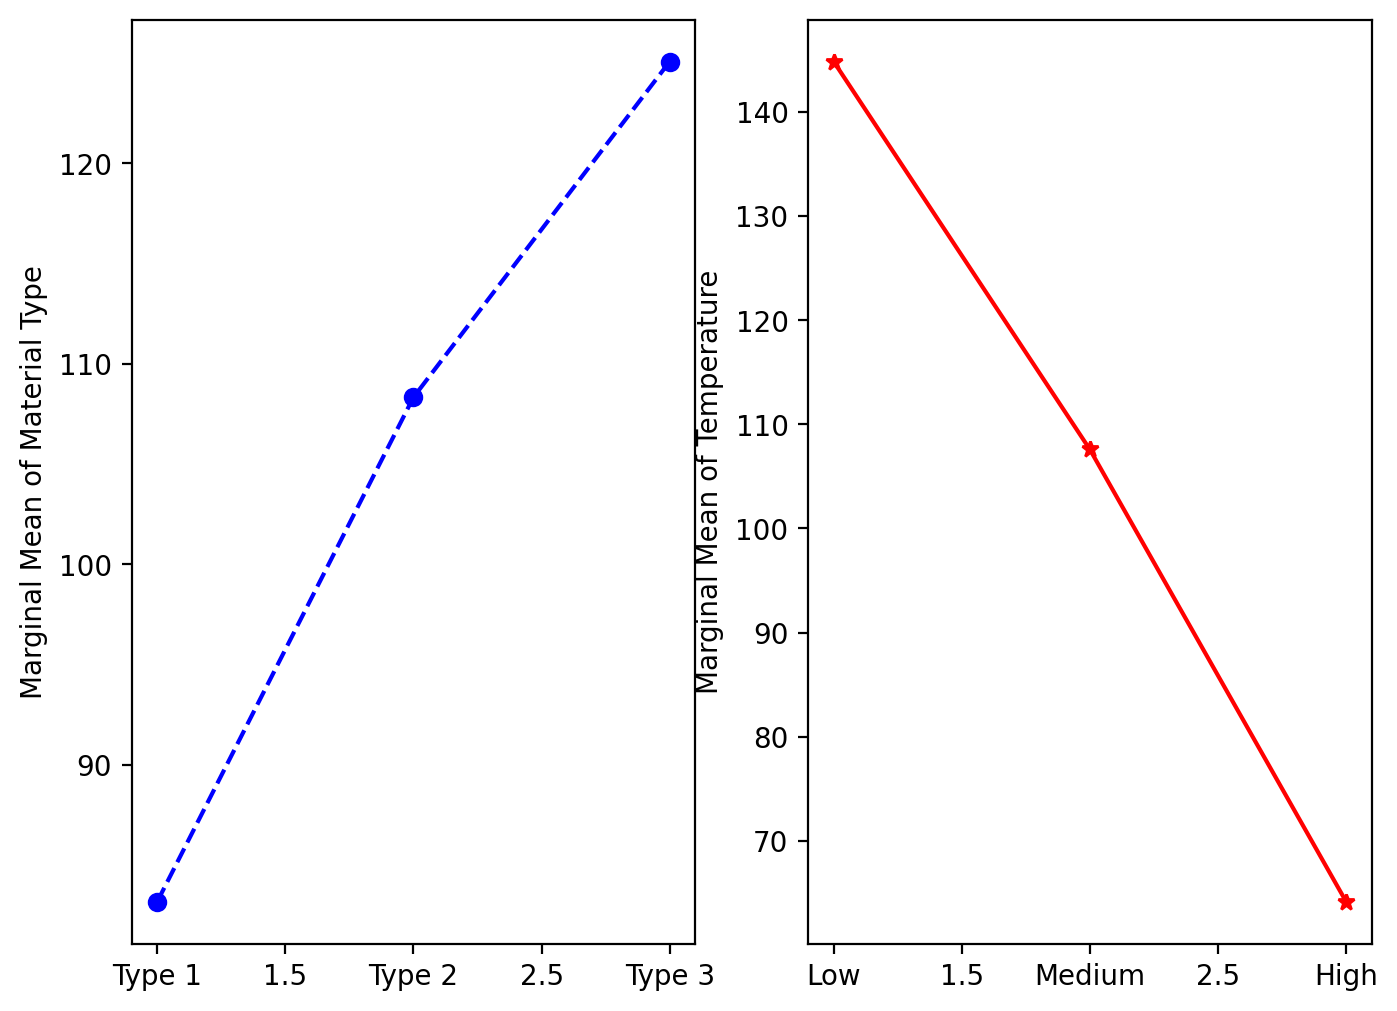

In [9]:
# construct one dataframe object for each combination of factor A group and factor B group
# in total, 9 combinations for this experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# construct a dataframe object for each combination
df = pd.DataFrame({"M1-Low": [130, 155, 74, 180]})
df1 = pd.DataFrame({"M1-Med": [34, 40, 80, 75]})
df2 = pd.DataFrame({"M1-High": [20, 70, 82, 58]})
df3 = pd.DataFrame({"M2-Low": [150, 188, 159, 126]})
df4 = pd.DataFrame({"M2-Med": [136, 122, 106, 115]})
df5 = pd.DataFrame({"M2-High": [25, 70, 58, 45]})
df6 = pd.DataFrame({"M3-Low": [138, 110, 168, 160]})
df7 = pd.DataFrame({"M3-Med": [174, 120, 150, 139]})
df8 = pd.DataFrame({"M3-High": [96, 104, 82, 60]})

# merge all dataframe objects
dataframe_ob_two = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8], axis=1)

# compute the marginal mean for each material type, for M1, compute average of combinations M1-Low, M1-med, and M1-high
# for M2, compute average of combinations M2-Low, M2-med, and M2-high
# for M3, compute average of combinations M3-Low, M3-med, and M3-high
Marginal_Mean_M1 = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M1-Low"].values,
            dataframe_ob_two["M1-Med"].values,
            dataframe_ob_two["M1-High"].values,
        ),
        axis=None,
    )
)
Marginal_Mean_M2 = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M2-Low"].values,
            dataframe_ob_two["M2-Med"].values,
            dataframe_ob_two["M2-High"].values,
        ),
        axis=None,
    )
)
Marginal_Mean_M3 = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M3-Low"].values,
            dataframe_ob_two["M3-Med"].values,
            dataframe_ob_two["M3-High"].values,
        ),
        axis=None,
    )
)

# generate 8 in x 6 in plot, dpi=200
fig = plt.figure(figsize=(8, 6), dpi=200)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# plot for marginal means of 3 material types
ax1.plot(
    [1, 2, 3],
    [Marginal_Mean_M1, Marginal_Mean_M2, Marginal_Mean_M3],
    linestyle="--",
    marker="o",
    color="b",
)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[1] = "Type 1"
labels[3] = "Type 2"
labels[5] = "Type 3"
ax1.set_xticklabels(labels)
ax1.set_ylabel("Marginal Mean of Material Type")

# compute the marginal mean for temperature, for low, compute average of combinations M1-Low, M2-low, and M3-low
# for med, compute average of combinations M1-med, M2-med, and M3-med
# for high, compute average of combinations M1-high, M2-high, and M3-high
Marginal_Mean_Low = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M1-Low"].values,
            dataframe_ob_two["M2-Low"].values,
            dataframe_ob_two["M3-Low"].values,
        ),
        axis=None,
    )
)
Marginal_Mean_Med = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M1-Med"].values,
            dataframe_ob_two["M2-Med"].values,
            dataframe_ob_two["M3-Med"].values,
        ),
        axis=None,
    )
)
Marginal_Mean_High = np.mean(
    np.concatenate(
        (
            dataframe_ob_two["M1-High"].values,
            dataframe_ob_two["M2-High"].values,
            dataframe_ob_two["M3-High"].values,
        ),
        axis=None,
    )
)

# plot for marginal means of 3 levels of temperature
ax2.plot(
    [1, 2, 3],
    [Marginal_Mean_Low, Marginal_Mean_Med, Marginal_Mean_High],
    linestyle="-",
    marker="*",
    color="r",
)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[1] = "Low"
labels[3] = "Medium"
labels[5] = "High"
ax2.set_xticklabels(labels)
ax2.set_ylabel("Marginal Mean of Temperature")

How to interpret the graphs?

If putting two lines into a single plot, then there is a crossing point, indicating interaction effect exists. That gives us a good idea what to expect, but we want to run a hypothesis test to be sure.

### 3.2 Hypothesis formulation

Three omnibus null hypotheses for this two-way ANOVA:

- **material effect** $H_0$ marginal mean for material1 = marginal mean for material2 = marginal mean for material3
- **temperature effect** $H_0$ marginal mean for low = marginal mean for medium = marginal mean for high
- **interaction effect** $H_0$ interaction effect between material and temperature is zero

### 3.3 Compute degrees of freedom

**TASK**

Calculate the degrees of freedom for SSA, SSB, SSAB and SSE. You can have a look at the lecture notes if you need to look up the formulas.

### 3.4 Compute critical regions

**TASK**

Now it's time for our critical value(s) approach again.

As usual: Given a Type I error 5%, use the inverse function of CDF of F-distribution to compute critical value(s) of one-sided critical regions for factor and interaction effects.

These are three separate tasks, so I will demonstrate it for the first of the two factor effects, and you can then try it out for the second factor and the interaction effects.

In [11]:
# DEMO: Factor effects for 'material'

# create empty plot to fill
x1 = np.linspace(-8, 8, 100)
plt.plot(x1, sts.f.pdf(x1, dof_SSA, dof_SSE, loc=0, scale=1), "r-", alpha=0.6)
plt.title("PDF of F-distribution for material effect test")
plt.ylabel("f(x)")
plt.xlabel("x")

# one sided test for alpha=0.05, with our DOF for SSA (as we denoted this our factor A) and SSE
C_value_material = sts.f.ppf(0.95, dof_SSA, dof_SSE, loc=0, scale=1)
print("critical value is", C_value_material)

# fill plot with critical value
x2 = np.linspace(C_value_material, 8, 100)
plt.fill_between(
    x2, sts.f.pdf(x2, dof_SSA, dof_SSE, loc=0, scale=1), color="purple", alpha=0.6
)
plt.annotate(
    "Critical Value is 3.354",
    (C_value_material, 0),
    (C_value_material - 1, 0.15),
    arrowprops=dict(
        arrowstyle="fancy",
        fc="0.3",
        ec="none",
        connectionstyle="angle3,angleA=0,angleB=-90",
    ),
)

NameError: name 'dof_SSE' is not defined

**TASK** Replicate the above for factor B (temperature) and the interaction effects. These should be two separate plots (one each).

In [ ]:
# Add your code here


### 3.5 Compute test statistics

We can now test our hypotheses. Remember that we had three:

- **material effect** $H_0$ marginal mean for material1 = marginal mean for material2 = marginal mean for material3
- **temperature effect** $H_0$ marginal mean for low = marginal mean for medium = marginal mean for high
- **interaction effect** $H_0$ interaction effect between material and temperature is zero

You will need to calculate the SSA, SSB, SSAB and SSE values. For that, you need to calculate the grand mean.

Because the sample sizes in all combination are 4, the grand mean can be computed by using either marginal means for material or marginal means for temperature. They will both result in the same value.

In [ ]:
# We calculate the marginal means earlier in 3.1, so if you get an error here double check whether you executed that cell

Marginal_Mean_material = [Marginal_Mean_M1,Marginal_Mean_M2,Marginal_Mean_M3]
Marginal_Mean_temperature = [Marginal_Mean_Low,Marginal_Mean_Med,Marginal_Mean_High]

grand_mean_two=np.mean(Marginal_Mean_material)

**TASK** 

Given the grand mean above, calculate SSA, SSB, SSAB and SSE. This follows the same approach as we did in 2.2, so check that out if you're not sure how to start.

In [ ]:
# Add your code here

**TASK**

After calculating these variations, we can then use our test statistic approach to make a decision for each of our hypotheses.

Check back to Task 2.3, as that was the same approach.

You'll need one test statistic each for the two factors. They are for example calculated as

test statistic A = (SSA/DOF_SSA) / (SSE/DOF_SSE)

for A, the equivalent for B and for AB (interaction).

In [ ]:
# Add your code here

### DEMO: Tukey-Kramer procedure

As you can see, we could reject all three of our null hypotheses. If we want to know WHERE the effects are happening, we can use the Tukey-Kramer approach to do that. I demonstrate how to use this approach below.

In [ ]:
# Step 1: Compute pairwise absolute difference between marginal sample means of factors material and temperature
Pair_Diff_material=np.zeros((3,3))
Pair_Diff_temperature=np.zeros((3,3))

#compute the pairwise absolute difference for distinctive pairs
for i in range(3):
    for j in range(3):
        if i > j :
            Pair_Diff_material[i,j]=abs(Marginal_Mean_material[i]-Marginal_Mean_material[j])
            Pair_Diff_temperature[i,j]=abs(Marginal_Mean_temperature[i]-Marginal_Mean_temperature[j])

# Step 2: Given Type I error 5% , compute the critical region for factor material and temperature by the inverse function of CDF of studentized range distribution
# for the use of studentized range distribution, refer to https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.studentized_range.html
critical_value_material_TK= sts.studentized_range.ppf(0.95,dof_SSA,dof_SSE,loc=0, scale=1)*np.sqrt((SSE/dof_SSE)/(3*4))
critical_value_temperature_TK= sts.studentized_range.ppf(0.95,dof_SSB,dof_SSE,loc=0, scale=1)*np.sqrt((SSE/dof_SSE)/(3*4))

# Step 3: Compare each pairwise absolute difference with the corresponding critical values.
for i in range(3):
    for j in range(3):
        if i > j :
            if Pair_Diff_material[i,j]>critical_value_material_TK:
                print('there is a significant difference in population mean between groups',i,'and',j, 'of factor material.')
            else:
                print('there is no difference in population mean between groups',i,'and',j, 'of factor material.')
            if Pair_Diff_temperature[i,j]>critical_value_temperature_TK:
                print('there is a significant difference in population mean between groups',i,'and',j, 'of factor temperature.')
            else:
                print('there is no difference in population mean between groups',i,'and',j, 'of factor temperature.')

there is a significant difference in population mean between groups 1 and 0 of factor material.
there is a significant difference in population mean between groups 1 and 0 of factor temperature.
there is a significant difference in population mean between groups 2 and 0 of factor material.
there is a significant difference in population mean between groups 2 and 0 of factor temperature.
there is no difference in population mean between groups 2 and 1 of factor material.
there is a significant difference in population mean between groups 2 and 1 of factor temperature.
